In [1]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np
import cpi

In [2]:
# Check that the CSV was read properly
movie_import = pd.read_csv("movies_metadata.csv", low_memory=False)
print(movie_import.shape)
movie_import.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
movie_import.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [4]:
# Check the dataset's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_import["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_import["revenue"].value_counts())

Budget value counts:
budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
923             1
72500000        1
2160000         1
4439832         1
1254040         1
Name: count, Length: 1226, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
36565280.0        1
439564.0          1
35610100.0        1
10217873.0        1
1413000.0         1
Name: count, Length: 6863, dtype: int64


In [5]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["budget"] = pd.to_numeric(movie_import['budget'], errors='coerce', downcast='integer')
no_budget = movie_import["budget"]==0
no_budget

0        False
1        False
2         True
3        False
4         True
         ...  
45461     True
45462     True
45463     True
45464     True
45465     True
Name: budget, Length: 45466, dtype: bool

In [6]:
# Create a DataFrame from the last cell's result
no_budget_df = movie_import[no_budget]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_budget]
movie_import

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45402,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,293654,tt3761706,ru,Корпоратив,"Igor, a furniture store manager, tries to figu...",...,2014-09-18,0.0,89.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Corporate Event,False,3.5,4.0
45408,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,100152,tt0417949,ru,Марс,"Somewhere deep, deep in Russia there is a town...",...,2004-11-11,0.0,100.0,[],Released,NaN,Mars,False,5.0,2.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [7]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["revenue"] = pd.to_numeric(movie_import["revenue"], errors="coerce", downcast="float")
no_revenue = movie_import["revenue"]==0
no_revenue

0        False
1        False
3        False
5        False
6         True
         ...  
45402     True
45408     True
45409    False
45412    False
45422    False
Name: revenue, Length: 8893, dtype: bool

In [8]:
# Create a DataFrame from the last block's result
no_revenue_df = movie_import[no_revenue]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_revenue]
print(movie_import.shape)
movie_import

(5384, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45399,False,NaN,750000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,tt3805180,ru,Все и сразу,NaN,...,2014-06-05,3.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,False,6.0,4.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [9]:
# Check if there are any 0 values remaining for either budget or revenue
print(f"Budget check: ")
print(movie_import["budget"].min())
print(f"Revenue check: ")
print(movie_import["revenue"].min())

Budget check: 
1.0
Revenue check: 
1.0


In [10]:
# Further fitler down the original movie dataset by removing movies with budgets and revenues less than $1000
movie_prep1 = movie_import[movie_import["budget"]>=1000]
movie_prep1 = movie_import[movie_import["revenue"]>=1000]
movie_prep1

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,False,NaN,11000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,395834,tt5362988,en,Wind River,An FBI agent teams with the town's veteran gam...,...,2017-08-03,184770205.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Nothing is harder to track than the truth.,Wind River,False,7.4,181.0
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [11]:
# Make a new DataFrame and import the title column from the metadata and make a blank id column to be populate
movie_prep2 = pd.DataFrame(movie_prep1["original_title"])
movie_prep2.rename(columns={"original_title": "Title"}, inplace=True)
movie_prep2['id'] = ''
movie_prep2

,Title,id
0,Toy Story,
1,Jumanji,
3,Waiting to Exhale,
5,Heat,
8,Sudden Death,
...,...,...
45167,Wind River,
45250,சிவாஜி,
45409,Dikari,
45412,Про любоff,


In [12]:
movie_list = movie_prep2.sample(1000)
movie_list.reset_index(inplace=True, drop=True)
movie_list

,Title,id
0,Dredd,
1,ലോഹം,
2,Josh,
3,Snow White and the Huntsman,
4,Kiss of the Dragon,
...,...,...
995,Disturbing Behavior,
996,Finding Neverland,
997,Lucy,
998,San Francisco,


In [13]:
# Test a TMDB API call based on an index of the movie list and printing the json response
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/iz0gx0msnS2G2vUcmigSE7aN4CL.jpg",
            "genre_ids": [
                35
            ],
            "id": 243938,
            "original_language": "en",
            "original_title": "Hot Tub Time Machine 2",
            "overview": "After their first adventure with the \"Hot Tub Time Machine,\" Lou and Nick are living very well off their ill-gotten gains, while Jacob still cannot rely on Lou to be a positive role model. When an unknown assailant breaks into Lou's mansion and shoots him,\u00a0Nick and Jacob take him for another trip in the hot tub. They emerge in the year 2025, where they must figure out who shot Lou and prevent it from happening again.",
            "popularity": 13.072,
            "poster_path": "/p2KVIrzzuhPZNWRv8HUQeNJqAKY.jpg",
            "release_date": "2015-02-20",
            "title": "Hot Tub Time Machine 2",
            "video": false,
            

In [14]:
# Test an OMDB API call based on an index of the movie list and printing the json response
url = "http://www.omdbapi.com/?t="
api_key_url = "&apikey=" + omdb_api_key
movie_name=movie_list["Title"][250]
response = requests.get(url + movie_name + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Error": "Request limit reached!",
    "Response": "False"
}


In [15]:
# Loop through the CSV's Title column to call said movie from the API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

In [16]:
# View the movies not found in the database
unfound_movies

['Gangs of वासेपुर']

In [17]:
#Print the DataFrame along with it's shape
print(movie_list.shape)
movie_list

(1000, 2)


,Title,id
0,Dredd,49049
1,ലോഹം,338930
2,Josh,646700
3,Snow White and the Huntsman,58595
4,Kiss of the Dragon,2140
...,...,...
995,Disturbing Behavior,9424
996,Finding Neverland,866
997,Lucy,240832
998,San Francisco,43881


In [18]:
#Drop NaN rows
movie_list.dropna(how='any',inplace=True)
#Re-check size of Data Frame
movie_list.shape

(999, 2)

In [19]:
#Add columns name to the DataFrame
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,Dredd,49049,,,,,,,,,
1,ലോഹം,338930,,,,,,,,,
2,Josh,646700,,,,,,,,,
3,Snow White and the Huntsman,58595,,,,,,,,,
4,Kiss of the Dragon,2140,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
995,Disturbing Behavior,9424,,,,,,,,,
996,Finding Neverland,866,,,,,,,,,
997,Lucy,240832,,,,,,,,,
998,San Francisco,43881,,,,,,,,,


In [20]:
# Loop through each movie's title for the API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        #extracting genre names from list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        #extracting production_countries names from list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [21]:
print(movie_list.shape)
movie_list.head()

(999, 11)


,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,Dredd,49049,tt1343727,50000000,"Action, Science Fiction",41037742,95,28.103,2012-09-07,"South Africa, United Kingdom, United States of...",6.821
1,Loham,338930,tt4881242,1050255,"Action, Thriller",2250547,129,3.02,2015-08-20,India,4.0
2,Josh,646700,tt4559096,0,,0,13,1.096,2015-04-23,,0.0
3,Snow White and the Huntsman,58595,tt1735898,170000000,"Adventure, Fantasy, Drama",396600000,127,24.575,2012-05-30,United States of America,5.981
4,Kiss of the Dragon,2140,tt0271027,25000000,"Action, Crime, Thriller",64437847,98,19.421,2001-07-06,"France, United States of America",6.8


In [22]:
# Create a new "Year" column from the "release date" by making a new df converting to datetime
movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])

In [23]:
movie_list["Year"] = movie_list["release_date"].dt.year
# movie_list.drop("release_date", axis=1, inplace=True)

In [24]:
# Drop the old release date column and reorder the current DataFrame to be nicer
movie_list=movie_list[["Title", "Year", "id", "imdb_id", "genres", "runtime", "budget", "revenue", "production_countries",
           "popularity", "tmdb_rating"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0
2,Josh,2015,646700,tt4559096,,13,0,0,,1.096,0.0
3,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981
4,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8
...,...,...,...,...,...,...,...,...,...,...,...
995,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,5.7
996,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,7.323
997,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,6.439
998,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,6.721


In [25]:
# # Create a new "Year" column from the "release date" by making a new df converting to datetime
# movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
# movie_list["Year"] = movie_list["release_date"].dt.year
# # movie_list.drop("release_date", axis=1, inplace=True)
# # Drop the old release date column and reorder the current DataFrame to be nicer
# movie_list=movie_list[["Title", "Year", "id", "imdb_id", "genres", "runtime", "budget", "revenue", "production_countries",
#            "popularity", "tmdb_rating"]]
# movie_list

In [26]:
## CARTER NOTE: I got some keyerrors and other odd occurences with the Year column being converted from release date
            #   properly. I think we could introduce some pacing to the code to take a tiny breath after doing
            #   pd.to_datetime, then one more tiny breath after doing the df[release_date].dt.year before reordering
            #   our columns. When I reran these blocks, things populated correctly which led me to believe the error
            #   was in our speed of running these in the first place.

In [27]:
# Check the DataFrame's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_list["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_list["revenue"].value_counts())

Budget value counts:
budget
0            39
40000000     34
25000000     34
50000000     32
30000000     31
             ..
645180        1
2224000       1
730000        1
950000        1
110000000     1
Name: count, Length: 262, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0            34
12000000      3
21000000      3
5000000       3
1600000       2
             ..
3494070       1
46495         1
868439        1
329398046     1
1929659       1
Name: count, Length: 940, dtype: int64


In [28]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_budget

0      False
1      False
2       True
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: budget, Length: 999, dtype: bool

In [29]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# Remove rows with zero budget values
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0
3,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981
4,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8
5,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,3.864
...,...,...,...,...,...,...,...,...,...,...,...
995,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,5.7
996,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,7.323
997,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,6.439
998,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,6.721


In [30]:
# View if a movie had 0 revenue or not (true/false)
no_revenue = movie_list["revenue"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_revenue

0      False
1      False
3      False
4      False
5      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: revenue, Length: 960, dtype: bool

In [31]:
# Removing rows with zero revenue movies
movie_list=movie_list[~no_revenue]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0
3,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981
4,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8
5,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,3.864
...,...,...,...,...,...,...,...,...,...,...,...
995,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,5.7
996,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,7.323
997,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,6.439
998,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,6.721


In [32]:
# Check if there are any 0 values remaining for either budget or revenue in the DataFrame
print(f"Budget check: ")
print(movie_list["budget"].min())
print(f"Revenue check: ")
print(movie_list["revenue"].min())

Budget check: 
1
Revenue check: 
1404


In [33]:
# # Dummy test on adjusting for inflation over the years using the cpi library
# budget_past = 438656843
# budget_year = 1991
# budget_2023 = cpi.inflate(budget_past, budget_year)
# round(budget_2023, 2)

In [34]:
# Create new columns in the DataFrame for inflation-adjusted budget and revenue
movie_list['infl_adj_budget'] = ''
movie_list['infl_adj_revenue'] = ''
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/455108519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = ''
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/455108519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_revenue'] = ''


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821,,
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0,,
3,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981,,
4,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8,,
5,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,3.864,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,5.7,,
996,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,7.323,,
997,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,6.439,,
998,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,6.721,,


In [35]:
# POSSIBLE TEMPORARY CODE 
# DROP ANY 2023 DATES TO FIX CPI FUNCTION
print("True = number of films from 2023")
drop23 = movie_list["Year"]==2023
drop23.value_counts()

True = number of films from 2023


Year
False    952
True       4
Name: count, dtype: int64

In [36]:
# POSSIBLE TEMPORARY CODE 
# DROP ANY 2023 DATES TO FIX CPI FUNCTION
movie_list = movie_list[movie_list["Year"]<2023]
print(movie_list.shape)
movie_list.head()

(952, 13)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821,,
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0,,
3,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981,,
4,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8,,
5,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,3.864,,


In [37]:
# POSSIBLE TEMPORARY CODE 
# NEW CODE FROM CARTER: I THINK WE (AGAIN) NEED TO RESET OUR INDEX AFTER DROPPING OUR NAN ROWS 
# AND MISSING BUDGET/REVENUE ROWS
movie_list.reset_index(inplace=True, drop=True)

In [38]:
# Defining a function to calculate a running inflation adjusted value for a column in a dataframe
def inflate_column(data, column):
    #     Adjust for inflation the series of values in column of the dataframe data
    return data.apply(lambda x: cpi.inflate(x[column], x.Year), axis=1)

# adjust the production budget 
movie_list.loc[:,'budget'] = movie_list['budget'].astype(int)
movie_list.loc[:,'infl_adj_budget'] = inflate_column(movie_list, 'budget')
#adjust the worldwide gross profits
movie_list.loc[:,'infl_adj_revenue'] = inflate_column(movie_list, 'revenue').astype(float)

# calculate the real worldwide net profit
movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/2404009855.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821,63733155.047606,52309295.473793,-1.142386e+07
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0,1296794.647747,2778846.37931,1.482052e+06
2,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981,216692727.16186,505531385.837609,2.888387e+08
3,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8,41312111.801242,106482541.579814,6.517043e+07
4,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,3.864,339901.277584,1971882.8777,1.631982e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,5.7,26931441.717791,31446910.870552,4.515469e+06
948,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,7.323,38731471.678137,180901622.266702,1.421702e+08
949,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,6.439,49448330.6299,567250975.170654,5.178026e+08
950,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,6.721,27370611.510791,111019411.151079,8.364880e+07


In [39]:
# Looking at a sampling of the dataframe
print(movie_list.shape)
movie_list.sample(5)

(952, 14)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit
327,Mulan,1998,10674,tt0120762,"Animation, Family, Adventure",88,90000000,304320254,United States of America,66.095,7.915,161588650.306748,546385545.609632,3.847969e+08
545,Hatchet II,2010,43919,tt1270835,"Horror, Comedy, Thriller",85,2500000,156190,United States of America,9.229,5.52,3355273.416003,209624.061938,-3.145649e+06
728,Nothing Left to Fear,2013,209901,tt1662293,Horror,100,3000000,1675381,United States of America,8.979,5.141,3768785.655722,2104717.293556,-1.664068e+06
56,Jefferson in Paris,1995,87729,tt0113463,"Drama, Romance, History",139,14000000,2474000,"France, United States of America",3.935,5.043,26884317.585302,4750842.979003,-2.213347e+07
584,Lovelace,2013,77805,tt1426329,Drama,92,10000000,1585582,United States of America,18.525,6.032,12562618.852406,1991906.232524,-1.057071e+07


In [40]:
for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        rating_url = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_rating"] = rating_url
        votes_url = url_byid_response['imdbVotes']
        movie_list.loc[index, "imdb_votes"] = votes_url
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/3153969870.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[index, "imdb_rating"] = np.nan
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/3153969870.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[index, "imdb_votes"] = np.nan


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821,63733155.047606,52309295.473793,-1.142386e+07,NaN,NaN
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0,1296794.647747,2778846.37931,1.482052e+06,NaN,NaN
2,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981,216692727.16186,505531385.837609,2.888387e+08,NaN,NaN
3,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8,41312111.801242,106482541.579814,6.517043e+07,NaN,NaN
4,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,3.864,339901.277584,1971882.8777,1.631982e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,5.7,26931441.717791,31446910.870552,4.515469e+06,NaN,NaN
948,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,7.323,38731471.678137,180901622.266702,1.421702e+08,NaN,NaN
949,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,6.439,49448330.6299,567250975.170654,5.178026e+08,NaN,NaN
950,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,6.721,27370611.510791,111019411.151079,8.364880e+07,7.2,"5,950"


# Movie Data Analysis

In [41]:
# Define custom bin edges
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels =["1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]

# Cut the data into custom intervals
movie_list.loc[:,'Decades'] = pd.cut(movie_list['Year'], bins=bin_edges,labels=labels)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/790854271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[:,'Decades'] = pd.cut(movie_list['Year'], bins=bin_edges,labels=labels)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821,63733155.047606,52309295.473793,-1.142386e+07,NaN,NaN,2010s
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,4.0,1296794.647747,2778846.37931,1.482052e+06,NaN,NaN,2010s
2,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,5.981,216692727.16186,505531385.837609,2.888387e+08,NaN,NaN,2010s
3,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,6.8,41312111.801242,106482541.579814,6.517043e+07,NaN,NaN,2000s
4,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,3.864,339901.277584,1971882.8777,1.631982e+06,NaN,NaN,1990s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,5.7,26931441.717791,31446910.870552,4.515469e+06,NaN,NaN,1990s
948,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,7.323,38731471.678137,180901622.266702,1.421702e+08,NaN,NaN,2000s
949,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,6.439,49448330.6299,567250975.170654,5.178026e+08,NaN,NaN,2010s
950,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,6.721,27370611.510791,111019411.151079,8.364880e+07,7.2,"5,950",1930s


In [42]:
# Sorting movie_list df revenue column ascending=False
sorted_revenue_desc = movie_list.sort_values(by='infl_adj_revenue', ascending=False)
top_ten_df = sorted_revenue_desc.iloc[0:10, :] 
top_ten_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades
919,The Sound of Music,1965,15121,tt0059742,"Drama, Family, Music, Romance",174,8200000,286214286,United States of America,22.479,7.701,76183206.349206,2659112440.29619,2.582929e+09,NaN,NaN,1960s
401,The Avengers,2012,24428,tt0848228,"Science Fiction, Action, Adventure",143,220000000,1518815515,United States of America,97.565,7.7,280425882.209465,1935978094.124084,1.655552e+09,NaN,NaN,2010s
429,The Lion King,2019,420818,tt6105098,"Adventure, Drama, Family",118,260000000,1663075401,"United Kingdom, United States of America",92.634,7.124,297626507.390762,1903751242.796618,1.606125e+09,NaN,NaN,2010s
215,Furious 7,2015,168259,tt2820852,"Action, Thriller, Crime",137,190000000,1515341399,United States of America,68.39,7.238,234601104.56212,1871056663.126885,1.636456e+09,NaN,NaN,2010s
803,Jurassic Park,1993,329,tt0107290,"Adventure, Science Fiction",127,63000000,920100000,United States of America,25.309,7.941,127593529.411765,1863473117.647059,1.735880e+09,NaN,NaN,1990s
714,Pinocchio,1940,10895,tt0032910,"Animation, Family",88,2600000,84300000,United States of America,36.19,7.103,54350214.285714,1762201178.571428,1.707851e+09,NaN,NaN,1930s
463,Ben-Hur,1959,665,tt0052618,"Action, Drama, History, Adventure",222,15000000,164000000,United States of America,22.236,7.866,150853092.783505,1649327147.766323,1.498474e+09,8.1,"248,461",1950s
260,Fantasia,1940,756,tt0032455,"Animation, Family",124,2280000,76411819,United States of America,32.621,7.359,47660957.142857,1597307206.388929,1.549646e+09,NaN,NaN,1930s
168,Iron Man 3,2013,68721,tt1300854,"Action, Adventure, Science Fiction",130,200000000,1215577205,United States of America,70.851,6.927,251252377.048125,1527083311.208828,1.275831e+09,NaN,NaN,2010s
690,Close Encounters of the Third Kind,1977,840,tt0075860,"Science Fiction, Drama",135,20000000,306889114,United States of America,19.971,7.4,96585808.580858,1482056661.017657,1.385471e+09,NaN,NaN,1970s


<Axes: title={'center': 'Top 10 Grossing Movies (1922-2022)'}, xlabel='Movie Titles', ylabel='Movie Revenue'>

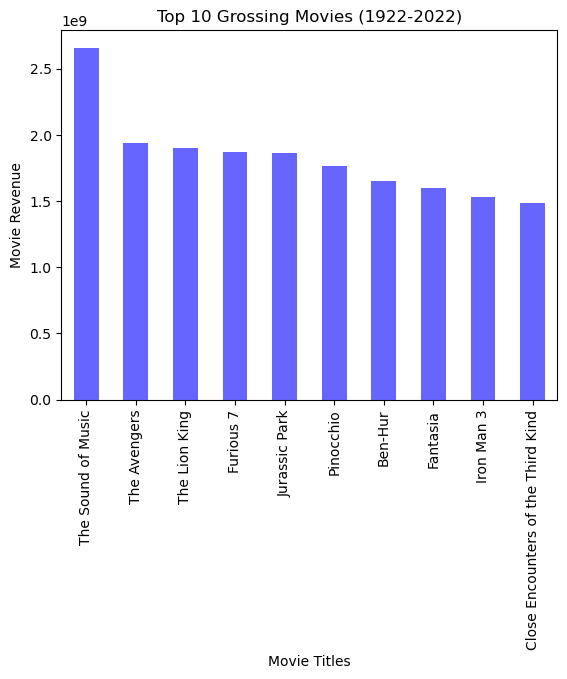

In [43]:
# Create a bar chart to display top 10 grossing movies

top_ten_df.plot("Title", "infl_adj_revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
                xlabel="Movie Titles", ylabel="Movie Revenue", legend='')


# ax=top_ten_df.plot("Title", "revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
#                 xlabel="Movie Titles", ylabel="Movie Revenue", legend='')
# ax.set_xticklabels(top_ten_df['Title'], rotation=45)
# plt.show()

In [44]:
# CARTER NOTE: I RAN INTO TWO INSTANCES OF TITANIC ONE TIME AROUND BUT COULDN'T DIAGNOSE BECAUSE OF THE INDECES NO
# LONGER BEING ACCURATE, SPURRING MY ADDITION OF THE RESET_INDEX AFTER DROPPING OUR EMPTY BUDGET AND REVENUE ROWS

# WITH THIS UPDATE, WE CAN MAYBE DIAGNOSE IF WE GET DUPLICATES IN ANOTHER RUN THROUGH OF THE CODE

<Axes: title={'center': 'Number of Movies per decade'}, xlabel='Decades', ylabel='Number of Movies'>

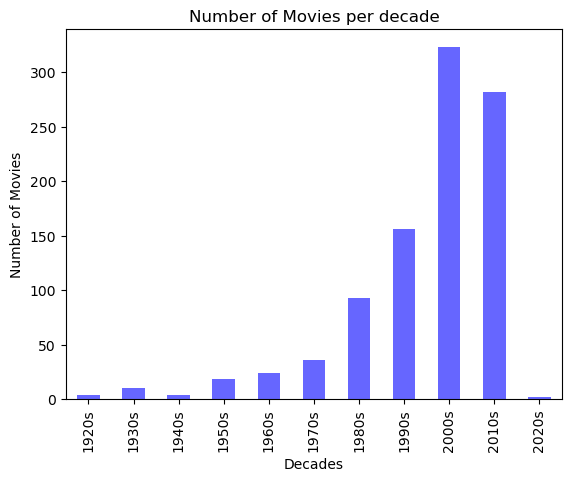

In [45]:
# Create a bar chart based upon the above data
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar', alpha=0.6, color='blue', title="Number of Movies per decade", xlabel="Decades", ylabel="Number of Movies")

## Pie Chart

In [46]:
# Minimum Budget
min_budget = movie_list['infl_adj_budget'].min()
# Average Budget
avg_budget = movie_list['infl_adj_budget'].mean()
# Maximum Budget
max_budget = movie_list['infl_adj_budget'].max()
diff = (max_budget-min_budget)/3
# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']
# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)
movie_list.sample(10)

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/3799777054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category
358,Last Holiday,2006,17379,tt0408985,"Adventure, Comedy, Drama",112,45000000,38399961,United States of America,12.632,7.086,65324776.785714,55743752.909003,-9.581024e+06,NaN,NaN,2000s,Low Budget
105,Chain Reaction,1996,12123,tt0115857,"Science Fiction, Action, Drama, Thriller",107,50000000,60209334,United States of America,16.34,5.687,93261631.612492,112304414.54283,1.904278e+07,NaN,NaN,1990s,Low Budget
697,Amélie,2001,194,tt0211915,"Comedy, Romance",122,10000000,173921954,"France, Germany",24.993,7.9,16524844.720497,287403328.33354,2.708785e+08,NaN,NaN,2000s,Low Budget
60,Cannonball,1976,21241,tt0074279,"Action, Comedy",93,780000,1500000,"United States of America, Hong Kong",8.608,5.516,4011790.86116,7714982.425308,3.703192e+06,NaN,NaN,1970s,Low Budget
510,Kung Fu Panda 2,2011,49444,tt1302011,"Animation, Family",91,150000000,665692281,United States of America,47.716,6.968,195156242.35904,866093360.849186,6.709371e+08,NaN,NaN,2010s,Average Budget
410,Courage Under Fire,1996,10684,tt0115956,"Drama, Thriller, Mystery, War",116,46000000,100860818,United States of America,12.628,6.458,85800701.083493,188128889.049012,1.023282e+08,NaN,NaN,1990s,Low Budget
277,A Company Man,2012,134126,tt2371486,"Drama, Action",96,3500000,7339398,South Korea,11.476,6.848,4461320.853332,9355259.813802,4.893939e+06,NaN,NaN,2010s,Low Budget
540,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195,United States of America,24.499,7.165,101776345.144357,302231952.445702,2.004556e+08,NaN,NaN,1990s,Low Budget
593,Wrath of the Titans,2012,57165,tt1646987,"Fantasy, Adventure",99,150000000,301970083,"Spain, United States of America",33.175,5.723,191199465.142817,384910122.391548,1.937107e+08,NaN,NaN,2010s,Average Budget
610,The Frighteners,1996,10779,tt0116365,"Horror, Comedy",110,30000000,29359216,"New Zealand, United States of America",18.161,6.9,55956978.967495,54761767.740472,-1.195211e+06,NaN,NaN,1990s,Low Budget


  Budget_Category  count
0      Low Budget    816
1  Average Budget    100
2     High Budget     34


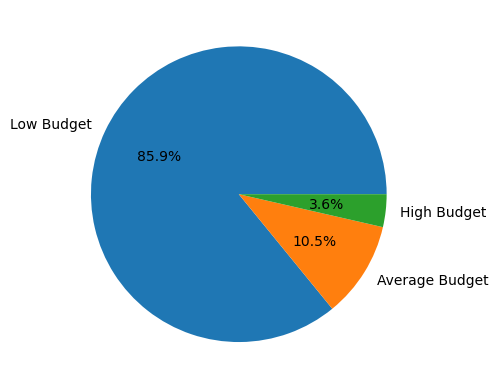

In [47]:
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.pie(y,autopct='%1.1f%%',labels=['Low Budget','Average Budget','High Budget'])
plt.show()

In [48]:
genre_df = movie_list.copy(deep=True)
# genre_df
genre_df[['primary_genre', 'sub_genre_1', 'sub_genre_2', 'sub_genre_3', 'sub_genre_4', 'sub_genre_5']] = genre_df['genres'].str.split(', ', expand=True, n=5)
genre_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,imdb_rating,imdb_votes,Decades,Budget_Category,primary_genre,sub_genre_1,sub_genre_2,sub_genre_3,sub_genre_4,sub_genre_5
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,...,NaN,NaN,2010s,Low Budget,Action,Science Fiction,None,None,None,None
1,Loham,2015,338930,tt4881242,"Action, Thriller",129,1050255,2250547,India,3.02,...,NaN,NaN,2010s,Low Budget,Action,Thriller,None,None,None,None
2,Snow White and the Huntsman,2012,58595,tt1735898,"Adventure, Fantasy, Drama",127,170000000,396600000,United States of America,24.575,...,NaN,NaN,2010s,High Budget,Adventure,Fantasy,Drama,None,None,None
3,Kiss of the Dragon,2001,2140,tt0271027,"Action, Crime, Thriller",98,25000000,64437847,"France, United States of America",19.421,...,NaN,NaN,2000s,Low Budget,Action,Crime,Thriller,None,None,None
4,Trois,2000,77908,tt0217107,"Drama, Thriller, Romance",93,200000,1160268,United States of America,1.377,...,NaN,NaN,1990s,Low Budget,Drama,Thriller,Romance,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,Disturbing Behavior,1998,9424,tt0134619,"Mystery, Horror, Science Fiction",84,15000000,17514980,"Australia, United States of America",14.68,...,NaN,NaN,1990s,Low Budget,Mystery,Horror,Science Fiction,None,None,None
948,Finding Neverland,2004,866,tt0308644,Drama,106,25000000,116766556,"United Kingdom, United States of America",13.675,...,NaN,NaN,2000s,Low Budget,Drama,None,None,None,None,None
949,Lucy,2014,240832,tt2872732,"Action, Science Fiction",89,40000000,458863600,France,39.516,...,NaN,NaN,2010s,Low Budget,Action,Science Fiction,None,None,None,None
950,San Francisco,1936,43881,tt0028216,"Drama, Music, Romance",115,1300000,5273000,United States of America,6.267,...,7.2,"5,950",1930s,Low Budget,Drama,Music,Romance,None,None,None


In [54]:

# colors = plt.cm.Paired(range(len(primary_genre)))
primary_genre = genre_df['primary_genre'].value_counts()
primary_genre_length = len(primary_genre)

# Make blank list for explode values and loop through the primary genre length to append 0 after 0.1 accordingly
explode = []
for i in range(primary_genre_length):
    if i == 0:
        explode.append(0.1)
    else:
        explode.append(0)
print(f"Number of primary genres: {len(primary_genre)}")
primary_genre

Number of primary genres: 18


primary_genre
Drama              234
Comedy             172
Action             151
Adventure           67
Horror              57
Thriller            49
Crime               41
Fantasy             32
Animation           29
Science Fiction     27
Family              20
Romance             14
Documentary         13
Mystery             12
Music               10
War                 10
Western              9
History              5
Name: count, dtype: int64

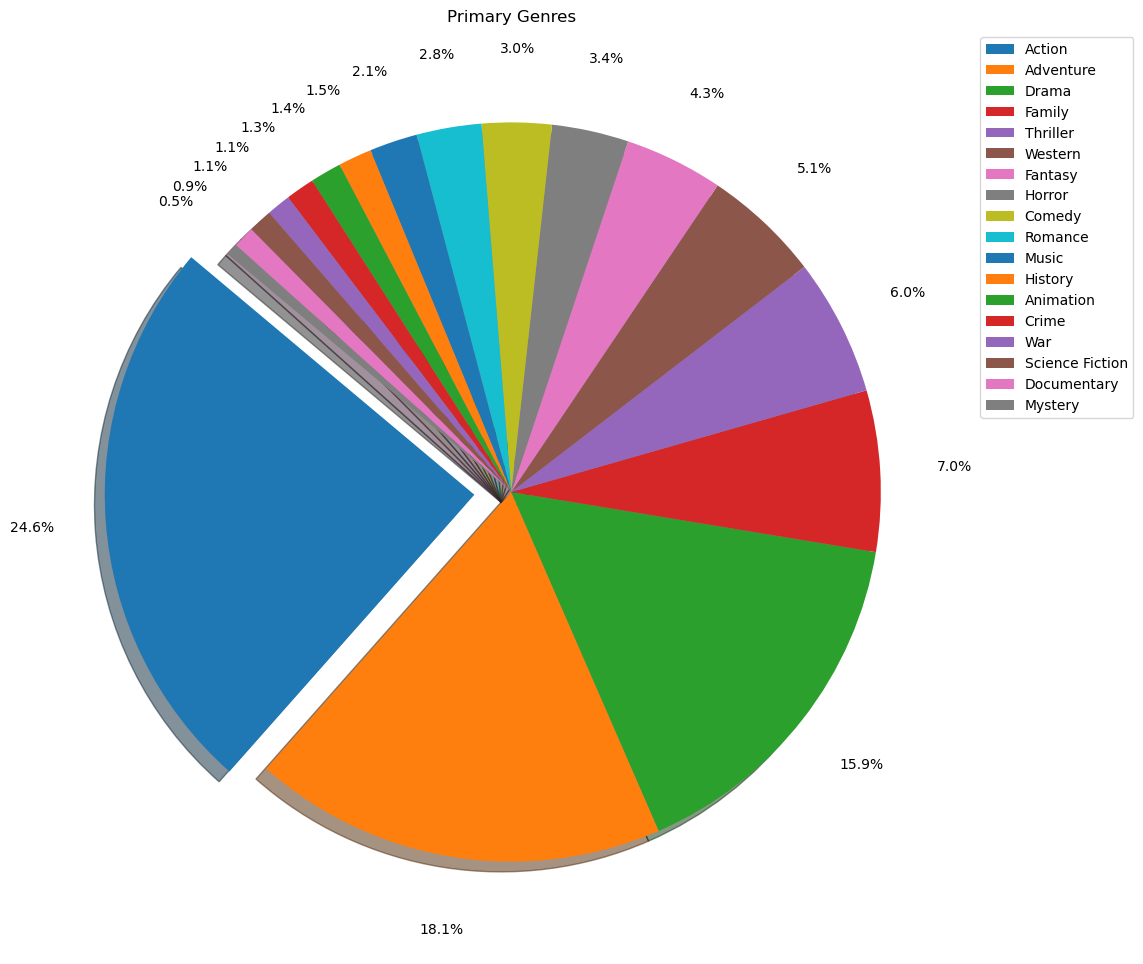

In [55]:
plt.figure(figsize=(12, 12))
categories = genre_df['primary_genre'].unique()
# This code would be to include 'exploding' the biggest value out but has an error when 'explode' list is not equal
# to length of primary genres
plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2, explode=explode)
# plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2)
plt.legend(categories, loc='best', bbox_to_anchor=(1, 1))
plt.title('Primary Genres')
plt.show()

## Bar Plot

<Figure size 1000x200 with 0 Axes>

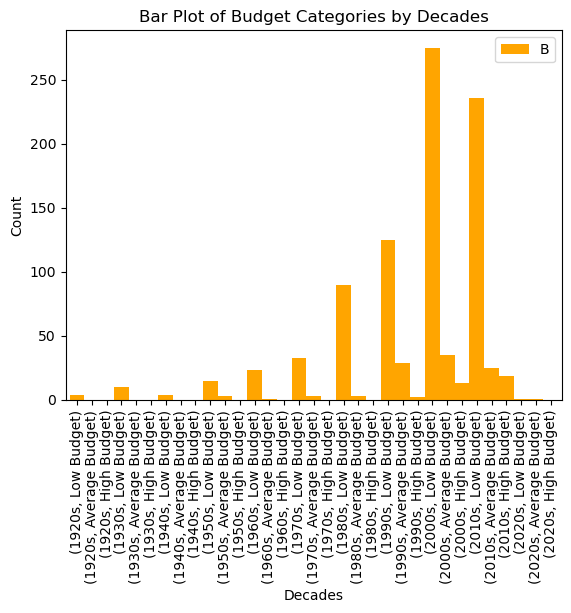

In [56]:
#Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()
pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])
# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches
# Create a stacked bar plot
pivot_df.plot(kind='bar',width=1,color='orange', stacked=True)
# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Bar Plot of Budget Categories by Decades')
plt.legend("Budget")
# Show the plot
plt.show()

## Histogram Plotting

Text(0.5, 1.0, 'Histogram of Budget')

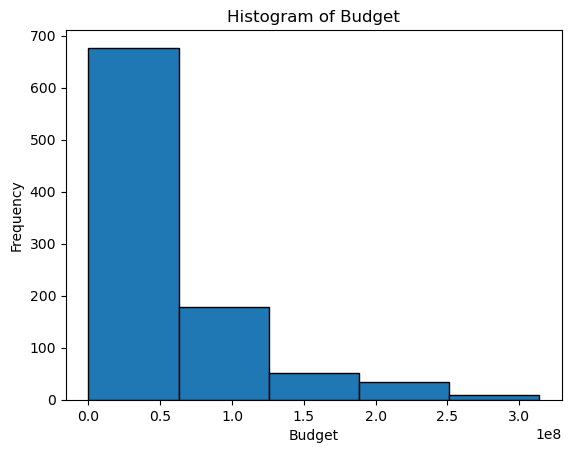

In [57]:
# Plot a histogram of budget
plt.hist(movie_list['infl_adj_budget'],bins=5, edgecolor='k')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title('Histogram of Budget')

In [58]:
# 
from scipy.stats import shapiro
DataToTest = movie_list['infl_adj_budget']
stat,p = shapiro(DataToTest)
print(f"stat: {stat},p: {p}")
if(p>0.05):
    print("Accept NULL Hypothesis :Budget data is normally Distributed")
else:
    print("Reject NULL Hypothesis: Budget data is not normally Distributed")

stat: 0.7945612668991089,p: 5.195296750156755e-33
Reject NULL Hypothesis: Budget data is not normally Distributed


## Scatter Plots with Linear Regression

In [59]:
# CARTER NOTE: THIS BLOCK BELOW DID NOT SHOW OUR FIRST SCATTER PLOT WHEN RUN FOR ME
    # Looking over the code, could the error be in the "xvalues = xval" lines?

In [60]:
# Creating a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    plt.show()

The r-value is:  -0.0937223962417272


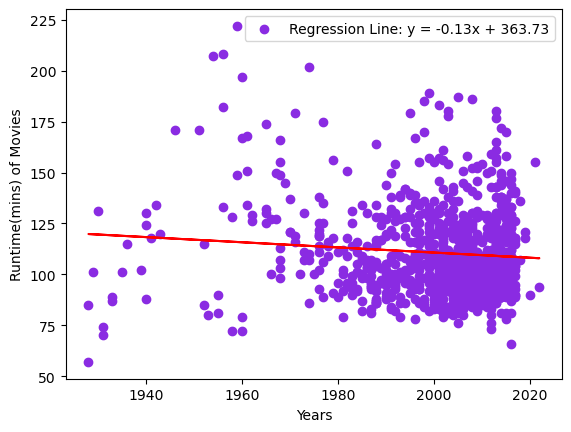

In [61]:
# Create a scatter plot for regression analysis

xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.020227547754707902


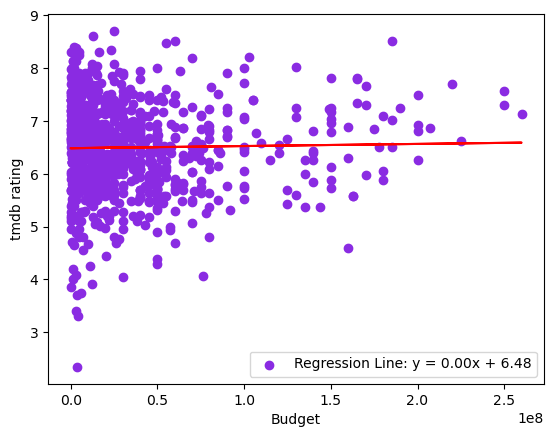

In [62]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='Budget'
y_label='tmdb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  nan


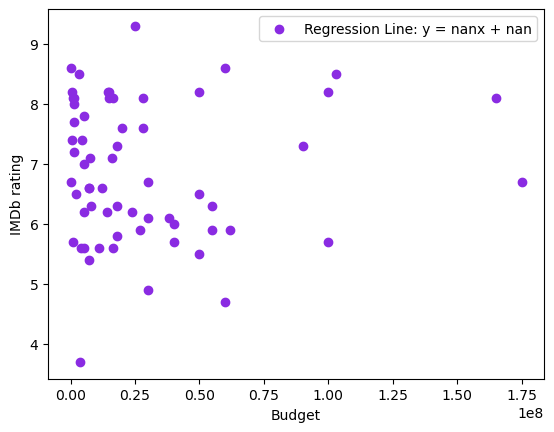

In [63]:
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget'
y_label='IMDb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  nan


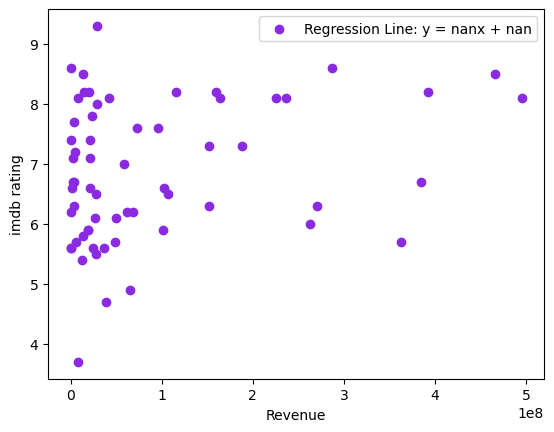

In [64]:
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue'
y_label='imdb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.19048834542474735


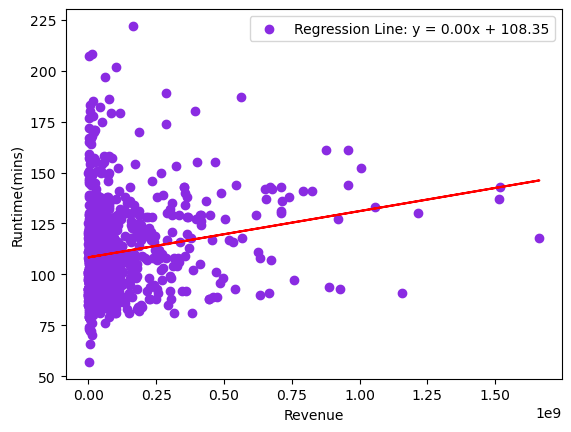

In [65]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue'
y_label='Runtime(mins)'

lin_regress(xval, yval, x_label, y_label)

# Data Testing

## 

In [66]:
#TEST NULL HYPOTHESIS(budget and revenue)
#H0: There is a significant association between budget and revenue of a movie.
#H1: There is no significant association between budget and revenue of a movie
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(movie_list['infl_adj_budget'], movie_list['infl_adj_revenue'])

# Perform the chi-square test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)

alpha = 0.05  # Significance level

if p < alpha:
    print("Accept Null Hypothesis: There is a significant association between budget and revenue of a movie.")
else:
    print("Reject Null Hypothesis:There is no significant association between budget and revenue.")

Chi-Square Statistic: 759696.0
P-value: 0.02596329538101387
Accept Null Hypothesis: There is a significant association between budget and revenue of a movie.


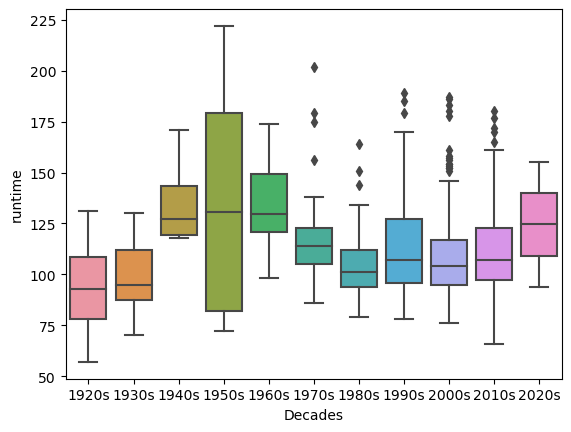

In [67]:
#Identifying Outliers in Movie Runtimes Over the Years
import seaborn as sns
ax = sns.boxplot(x='Decades',y='runtime',data=movie_list)

# Incorporating Oscar and Golden Globe Data

### Oscar dataset import and cleaning

In [68]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

(10765, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True


In [69]:
# Check for NaN values in the film column of the Oscar List
oscar_list["film"].isnull().value_counts()

film
False    10450
True       315
Name: count, dtype: int64

In [70]:
# Drop the NaN values and the "False" winners to clean the data
oscar_list.dropna(how="any", inplace=True)
oscar_winners = oscar_list["winner"]==True

oscars = oscar_list[oscar_winners]
print(oscars.shape)
oscars

(2149, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True
...,...,...,...,...,...,...,...
10743,2022,2023,95,SOUND,"Mark Weingarten, James H. Mather, Al Nelson, C...",Top Gun: Maverick,True
10745,2022,2023,95,VISUAL EFFECTS,"Joe Letteri, Richard Baneham, Eric Saindon and...",Avatar: The Way of Water,True
10753,2022,2023,95,WRITING (Adapted Screenplay),Screenplay by Sarah Polley,Women Talking,True
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True


In [71]:
# Count the number of wins each film has and turn that series into a DataFrame
oscar_wins = oscars[["film", "year_film"]].value_counts()
oscar_win_df = oscar_wins.reset_index()
oscar_win_df

,film,year_film,count
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


In [72]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
oscar_win_df = oscar_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Oscar_Wins'})
oscar_win_df

,Title,Year,Oscar_Wins
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


### Golden Globe dataset import and cleaning

In [73]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head()

# gglobe_list

(7991, 7)


,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [74]:
# Check for NaN values in the film column of the Golden Globe List
gglobe_list["film"].isnull().value_counts()

film
False    6191
True     1800
Name: count, dtype: int64

In [75]:
# CARTER NOTE: HERE WOULD BE WHERE WE COULD TRY TO ASSIGN THE NOMINEE VALUE TO ANY NaN FILM VALUES TO NOT LOSE TOO
    # MUCH OF OUR GGLOBE DATA

In [83]:
# Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
gglobe_winners = gglobe_list["win"]==True
# gglobe_winners
gglobes = gglobe_list[gglobe_winners]

# Update the 'film' column where it is NaN with values from the 'nominee' column
gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])
gglobes.sample(10)

# print(gglobes.shape)
# gglobes

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_87895/1505913114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])


,year_film,year_award,ceremony,category,nominee,film,win
4772,1994,1995,52,Best Television Series - Drama,"X-Files, The","X-Files, The",True
7909,2019,2020,77,Best Screenplay - Motion Picture,Quentin Tarantino,Once Upon a Time...in Hollywood,True
2277,1974,1975,32,New Star Of The Year - Actor,Joseph Bottoms,"Dove, The",True
704,1961,1962,19,Best Motion Picture - Drama,The Guns Of Navarone,The Guns Of Navarone,True
7504,2016,2017,74,Best Performance by an Actress in a Motion Pic...,Emma Stone,La La Land,True
1717,1970,1971,28,New Star Of The Year - Actress,Carrie Snodgress,Diary of a Mad Housewife,True
7152,2013,2014,71,Best Screenplay - Motion Picture,Spike Jonze,Her,True
2230,1974,1975,32,Best Television Series - Drama,Upstairs/Downstairs,Upstairs/Downstairs,True
2739,1978,1979,36,Best Television Series - Musical or Comedy,Taxi,Taxi,True
6121,2005,2006,63,Best Performance by an Actor in a Motion Pictu...,Joaquin Phoenix,Walk The Line,True


In [ ]:
# # Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
# gglobe_winners = gglobe_list["win"]==True
# gglobe_winners

# gglobes = gglobe_list[gglobe_winners]
# print(gglobes.shape)
# gglobes

In [84]:
# Count the number of wins each film has and turn that series into a DataFrame
gglobe_count = gglobes[["film", "year_film"]].value_counts()
gglobe_win_df = gglobe_count.reset_index()
gglobe_win_df

,film,year_film,count
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


In [85]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
gglobe_win_df = gglobe_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Golden_Globe_Wins'})
gglobe_win_df

,Title,Year,Golden_Globe_Wins
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


## Merging the Oscars and Golden Globes DataFrames into the Movie List DataFrame

In [86]:
# Referencing the movie_list for ease of coding
print(movie_list.shape)
movie_list.head(1)

(952, 18)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category
0,Dredd,2012,49049,tt1343727,"Action, Science Fiction",95,50000000,41037742,"South Africa, United Kingdom, United States of...",28.103,6.821,63733155.047606,52309295.473793,-1.142386e+07,NaN,NaN,2010s,Low Budget


In [90]:
# Individually merge the Oscars and Golden Globes DataFrames into the master movie list
oscar_awards = pd.merge(movie_list, oscar_win_df, how="inner", on=["Title", "Year"])
print(oscar_awards.shape)
oscar_awards.head()

(82, 19)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category,Oscar_Wins
0,Gladiator,2000,98,tt0172495,"Action, Drama, Adventure",155,103000000,465361176,"United Kingdom, United States of America",64.293,8.209,175049157.955865,790884291.302439,6.158351e+08,8.5,"1,566,334",1990s,Average Budget,5
1,"Crouching Tiger, Hidden Dragon",2000,146,tt0190332,"Adventure, Drama, Action, Romance",120,17000000,213525736,"China, Hong Kong, Taiwan, United States of Ame...",19.461,7.409,28891608.594657,362888352.317538,3.339967e+08,NaN,NaN,1990s,Low Budget,4
2,Ghost,1990,251,tt0099653,"Fantasy, Drama, Thriller, Mystery, Romance",127,22000000,505000000,United States of America,35.692,7.206,49260979.342005,1130763389.441469,1.081502e+09,NaN,NaN,1980s,Low Budget,2
3,Brave,2012,62177,tt1217209,"Animation, Adventure, Comedy, Family, Action, ...",93,185000000,538983207,United States of America,51.527,7.013,235812673.676141,687022005.995736,4.512093e+08,NaN,NaN,2010s,High Budget,1
4,Spartacus,1960,967,tt0054331,"History, War, Drama, Adventure",197,12000000,60000000,United States of America,37.501,7.5,118643918.918919,593219594.594595,4.745757e+08,NaN,NaN,1950s,Average Budget,4


In [89]:
gglobe_awards = pd.merge(movie_list, gglobe_win_df, how="inner", on=["Title", "Year"])
print(gglobe_awards.shape)
gglobe_awards.head()

(46, 19)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category,Golden_Globe_Wins
0,Big,1988,2280,tt0094737,"Fantasy, Drama, Comedy, Romance, Family",104,18000000,151927281,United States of America,20.786,7.164,44529078.613694,375843435.511877,3.313144e+08,7.3,"233,986",1980s,Low Budget,1
1,Marathon Man,1976,10518,tt0074860,Thriller,125,6500000,21709020,United States of America,12.808,7.215,33431590.509666,111656471.8471,7.822488e+07,NaN,NaN,1970s,Low Budget,1
2,Gladiator,2000,98,tt0172495,"Action, Drama, Adventure",155,103000000,465361176,"United Kingdom, United States of America",64.293,8.209,175049157.955865,790884291.302439,6.158351e+08,8.5,"1,566,334",1990s,Average Budget,3
3,"Crouching Tiger, Hidden Dragon",2000,146,tt0190332,"Adventure, Drama, Action, Romance",120,17000000,213525736,"China, Hong Kong, Taiwan, United States of Ame...",19.461,7.409,28891608.594657,362888352.317538,3.339967e+08,NaN,NaN,1990s,Low Budget,1
4,Ghost,1990,251,tt0099653,"Fantasy, Drama, Thriller, Mystery, Romance",127,22000000,505000000,United States of America,35.692,7.206,49260979.342005,1130763389.441469,1.081502e+09,NaN,NaN,1980s,Low Budget,1


In [91]:
# Make a DataFrame merging Golden Globe Awards data onto the merged Oscar data to show only films with wins in both
both_awards = pd.merge(oscar_awards, gglobe_win_df, how="inner", on=["Title", "Year"])
print(both_awards.shape)
both_awards

(32, 20)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins
0,Gladiator,2000,98,tt0172495,"Action, Drama, Adventure",155,103000000,465361176,"United Kingdom, United States of America",64.293,8.209,175049157.955865,790884291.302439,6.158351e+08,8.5,"1,566,334",1990s,Average Budget,5,3
1,"Crouching Tiger, Hidden Dragon",2000,146,tt0190332,"Adventure, Drama, Action, Romance",120,17000000,213525736,"China, Hong Kong, Taiwan, United States of Ame...",19.461,7.409,28891608.594657,362888352.317538,3.339967e+08,NaN,NaN,1990s,Low Budget,4,1
2,Ghost,1990,251,tt0099653,"Fantasy, Drama, Thriller, Mystery, Romance",127,22000000,505000000,United States of America,35.692,7.206,49260979.342005,1130763389.441469,1.081502e+09,NaN,NaN,1980s,Low Budget,2,1
3,Brave,2012,62177,tt1217209,"Animation, Adventure, Comedy, Family, Action, ...",93,185000000,538983207,United States of America,51.527,7.013,235812673.676141,687022005.995736,4.512093e+08,NaN,NaN,2010s,High Budget,1,1
4,Spartacus,1960,967,tt0054331,"History, War, Drama, Adventure",197,12000000,60000000,United States of America,37.501,7.5,118643918.918919,593219594.594595,4.745757e+08,NaN,NaN,1950s,Average Budget,4,1
5,Evita,1996,8818,tt0116250,"History, Drama, Music",135,55000000,141047179,"United States of America, Hungary",11.95,6.125,102587794.773741,263085800.957584,1.604980e+08,NaN,NaN,1990s,Low Budget,1,3
6,Rocky,1976,1366,tt0075148,"Drama, Romance",119,1000000,225250402,United States of America,65.579,7.786,5143321.616872,1158535261.815641,1.153392e+09,8.1,"610,590",1970s,Low Budget,3,1
7,The Alamo,1960,11209,tt0053580,Western,167,12000000,7900000,United States of America,8.604,7.182,118643918.918919,78107246.621622,-4.053667e+07,NaN,NaN,1950s,Average Budget,1,1
8,Sophie's Choice,1982,15764,tt0084707,"Drama, Romance, War",151,12000000,30036000,"United Kingdom, United States of America",13.456,7.336,36392331.606218,91090006.010363,5.469767e+07,NaN,NaN,1980s,Low Budget,1,1
9,There Will Be Blood,2007,7345,tt0469494,Drama,158,25000000,77208711,United States of America,25.228,8.085,35286507.316414,108977029.823697,7.369052e+07,NaN,NaN,2000s,Low Budget,2,1


In [92]:
# Sum the Oscar and Golden Globe Award wins into a new column called cumulative awards
both_awards['Cumulative_Awards'] = ''
for index,row in both_awards.iterrows():
    both_awards.loc[index, "Cumulative_Awards"] = both_awards.loc[index,'Oscar_Wins']+both_awards.loc[index,'Golden_Globe_Wins']

both_awards.sort_values(by='Cumulative_Awards',ascending = False,inplace=True)
both_awards.head(50)

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
18,Ben-Hur,1959,665,tt0052618,"Action, Drama, History, Adventure",222,15000000,164000000,United States of America,22.236,...,150853092.783505,1649327147.766323,1.498474e+09,8.1,"248,461",1950s,Average Budget,11,3,14
30,La La Land,2016,313369,tt3783958,"Comedy, Drama, Romance, Music",129,30000000,447407695,"Hong Kong, United States of America",33.205,...,36580808.059765,545551167.175228,5.089704e+08,NaN,NaN,2010s,Low Budget,6,7,13
17,West Side Story,1961,1725,tt0055614,"Crime, Drama, Romance",151,6000000,43656822,United States of America,11.954,...,58726755.852843,427303921.150836,3.685772e+08,NaN,NaN,1960s,Low Budget,10,3,13
10,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,59.908,...,108610155.195682,1337657908.407422,1.229048e+09,NaN,NaN,1990s,Average Budget,6,3,9
0,Gladiator,2000,98,tt0172495,"Action, Drama, Adventure",155,103000000,465361176,"United Kingdom, United States of America",64.293,...,175049157.955865,790884291.302439,6.158351e+08,8.5,"1,566,334",1990s,Average Budget,5,3,8
27,Network,1976,10774,tt0074958,Drama,122,3800000,23689877,United States of America,17.81,...,19544622.144112,121844656.475132,1.023000e+08,NaN,NaN,1970s,Low Budget,4,4,8
14,High Noon,1952,288,tt0044706,"Western, Drama",85,730000,8000000,United States of America,20.573,...,8061816.981132,88348679.245283,8.028686e+07,NaN,NaN,1950s,Low Budget,4,4,8
26,Unforgiven,1992,33,tt0105695,Western,130,14400000,159157447,United States of America,32.836,...,30037291.518175,331990182.835246,3.019529e+08,8.2,"426,855",1990s,Low Budget,4,2,6
31,Rain Man,1988,380,tt0095953,Drama,134,25000000,354825435,United States of America,20.364,...,61845942.519019,877780538.291843,8.159346e+08,NaN,NaN,1980s,Low Budget,4,2,6
29,Working Girl,1988,3525,tt0096463,"Comedy, Romance, Drama",114,28000000,103173635,United States of America,17.762,...,69267455.621302,255234827.987532,1.859674e+08,NaN,NaN,1980s,Low Budget,1,4,5


In [93]:
# Sort the data descending and grab the top 20 cumulative winners to do visualizations with
top20_both_awards = both_awards.sort_values(by='Cumulative_Awards', ascending=False)
top20_movies = top20_both_awards.iloc[0:20, :] 
top20_movies.head()

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
18,Ben-Hur,1959,665,tt0052618,"Action, Drama, History, Adventure",222,15000000,164000000,United States of America,22.236,...,150853092.783505,1649327147.766323,1.498474e+09,8.1,"248,461",1950s,Average Budget,11,3,14
17,West Side Story,1961,1725,tt0055614,"Crime, Drama, Romance",151,6000000,43656822,United States of America,11.954,...,58726755.852843,427303921.150836,3.685772e+08,NaN,NaN,1960s,Low Budget,10,3,13
30,La La Land,2016,313369,tt3783958,"Comedy, Drama, Romance, Music",129,30000000,447407695,"Hong Kong, United States of America",33.205,...,36580808.059765,545551167.175228,5.089704e+08,NaN,NaN,2010s,Low Budget,6,7,13
10,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,59.908,...,108610155.195682,1337657908.407422,1.229048e+09,NaN,NaN,1990s,Average Budget,6,3,9
0,Gladiator,2000,98,tt0172495,"Action, Drama, Adventure",155,103000000,465361176,"United Kingdom, United States of America",64.293,...,175049157.955865,790884291.302439,6.158351e+08,8.5,"1,566,334",1990s,Average Budget,5,3,8


<BarContainer object of 20 artists>

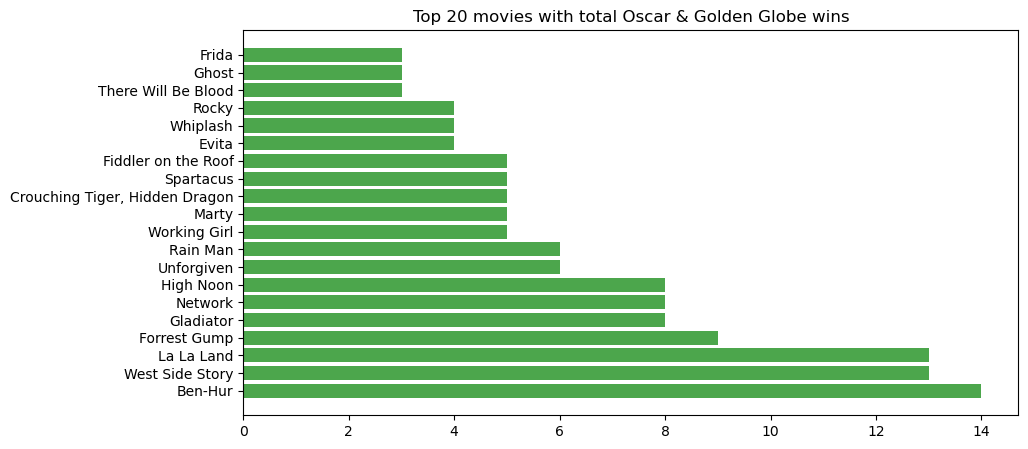

In [94]:
# plt.barh(x, y)
x=top20_movies['Title']
y=top20_movies['Cumulative_Awards']
plt.figure(figsize=(10,5))
plt.title('Top 20 movies with total Oscar & Golden Globe wins')
plt.barh(x,y,color='green',alpha=0.7)

In [95]:
# Take a look at how many awards were won by each decade
per_decade_wins=both_awards['Decades'].value_counts()
per_decade_wins

Decades
1990s    7
2000s    7
1950s    5
1980s    4
1960s    3
1970s    3
2010s    3
1920s    0
1930s    0
1940s    0
2020s    0
Name: count, dtype: int64

<BarContainer object of 11 artists>

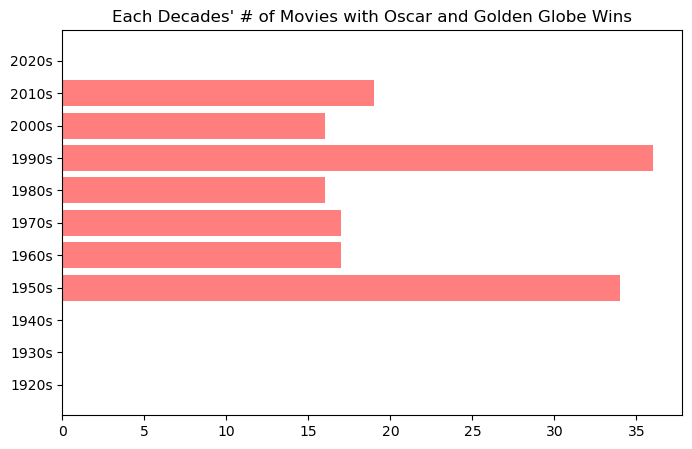

In [96]:
# Bar plot for cumulative Oscar and Golden Globe wins by Decade
decade_groupby = both_awards.groupby('Decades')
decades_sum=decade_groupby['Cumulative_Awards'].sum().reset_index()
decades_sum['Cumulative_Awards']
x=decades_sum['Decades']
y=decades_sum['Cumulative_Awards']
#plt.xlabel("Total oscar and golden globe wins")

plt.figure(figsize=(8,5))
plt.title(f"Each Decades' # of Movies with Oscar and Golden Globe Wins")
plt.barh(x,y,color='red',alpha=0.5)

### Pulling genre and produciton country information out of the DataFrame

In [ ]:
# # Testing the Pandas "explode" function
# checkexplode = movie_list["genres"].explode('drama')
# checkexplode